# Traffic Flow PDE I

Transport PDE (Lighthill-Whitham-Richards model) to simulate the **forward-propagating** movement of cars (as a shock wave) at the **green light**. 

In [3]:
import numpy
from matplotlib import pyplot

pyplot.style.use('seaborn')

Transport PDE:

$$\frac{\partial \rho}{\partial t}+\frac{\partial F}{\partial x}=0$$

**We solve for $\rho(x,t)$**

It is derived from the **non-linear convection PDE**. See derivation in Prof L. Barba notebook (Module 3 Lesson 1) from Equation (4) and (5).

Shorter form: $\rho_t + F_x=0$

Where, $F=\rho u=\rho \cdot u_{max}(1-\frac{\rho}{\rho_{max}})$

* $F$ is flux in the unit of $\frac{quantity}{time}$, where in this car traffic case is $\frac{cars}{hour}$. 
* $u_{max}$ is maximum velocity in $\frac{meter}{hour}$ 
* $\rho_{max}$ is maximum density in $\frac{cars}{meter}$.

**Solving the PDE** with forward-time/backward-space scheme:

\begin{equation}
\frac{\rho^{n+1}_i- \rho^n_{i}}{\Delta t}+ \frac{F^n_{i}-F^n_{i-1}}{\Delta x}=0
\end{equation}

Time extrapolation:

$$\rho_{i}^{n+1}=\rho_{i}^{n}-\frac{\Delta t}{\Delta x} (F_{i}^{n}-F_{i-1}^{n})$$

Initial condition:

\begin{equation}
\rho(x,0) = \left\{
\begin{array}{cc}
\rho_{\rm max}\frac{x}{2} & 0 \leq x < 2  \\
0 & 2 \leq x \leq 4 \\
\end{array}
\right.
\end{equation}

CFL:

$$\frac{u_{max} \Delta t}{\Delta x} \leq 1$$

## Evaluate initial condition

In [4]:
def initialize_traffic(nx, L, rho_max):
    # Traffic flow PDE initial condition
    # rho: car density along the road with length L
    
    # Discretize the domain.
    x = numpy.linspace(0.0, L, num=nx)  

    rho0 = numpy.zeros_like(x)
    mask = numpy.where(x < 2.0)
    rho0[mask] = rho_max * x[mask] / 2.0
    
    # Plot the initial car density on the road.
    pyplot.figure(figsize=(6.0, 4.0))
    pyplot.xlabel(r'$x$')
    pyplot.ylabel(r'$\rho$')
    pyplot.grid()
    pyplot.plot(x, rho0, color='C0', linestyle='-', linewidth=2)
    pyplot.xlim(0.0, L)
    pyplot.ylim(-0.5, 11.0);   
    pyplot.grid()
    
    return rho0   

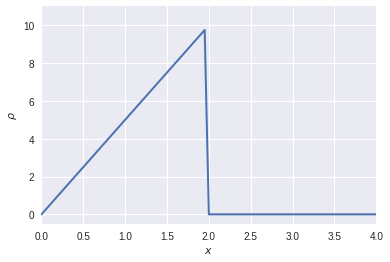

In [5]:
# set parameters for initial condition
nx = 81 # number of locations along the road
L = 4 # length of road
rho_max = 10 # car density along the road

rho0 = initialize_traffic(nx, L, rho_max)

## Evaluate flux

Flux `F` is inside the PDE. Make a function for flux.

In [6]:
def traffic_flux(rho, rho_max, u_max):
    # Flux    
    F = rho * u_max * (1.0 - rho / rho_max)
    return F    

## Solving PDE

In [7]:
def traffic_cfl(nt, rho0, L, nx, sigma, bc_value, rho_max, u_max):
    # rho0 is initial condition
    
    # calculate dx
    dx = L / (nx - 1)
    
    # calculate dt from CFL
    dt = sigma * dx / u_max  # time-step size    
    
    # Discretize the domain.
    x = numpy.linspace(0.0, L, num=nx)     
    
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        # Compute the flux.
        F = traffic_flux(rho, rho_max, u_max)
        # Advance in time.
        rho[1:] = rho[1:] - dt / dx * (F[1:] - F[:-1])
        # Set the left boundary condition.
        rho[0] = bc_value
        # Record the time-step solution.
        rho_hist.append(rho.copy())

    # Plot the initial traffic density.
    fig = pyplot.figure(figsize=(6.0, 4.0))
    pyplot.xlabel(r'$x$')
    pyplot.ylabel(r'$\rho$')
    pyplot.grid()
    pyplot.plot(x, rho0, label='Initial',
                color='C0', linestyle='--', linewidth=2)
    pyplot.plot(x, rho, label='nt = {}'.format(nt),
                color='C1', linestyle='-', linewidth=2)
    pyplot.xlim(0.0, L)
    pyplot.ylim(-0.5, 11.0)
    fig.tight_layout()        

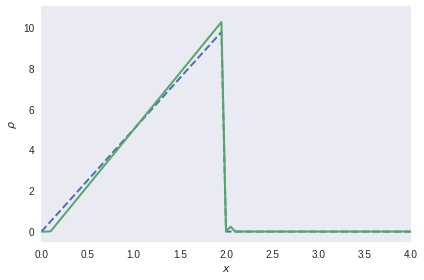

In [8]:
# Set parameters for simulation
nt = 30
L = 4
nx = 81
sigma = 1
bc_value = rho0[0]
u_max = 1

# timestep 2
traffic_cfl(2, rho0, L, nx, sigma, bc_value, rho_max, u_max)

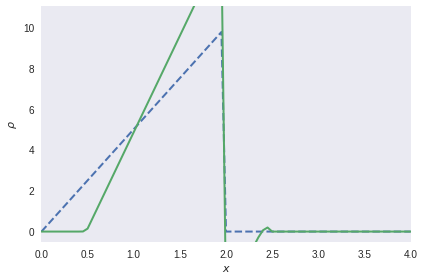

In [9]:
# timestep 10
traffic_cfl(10, rho0, L, nx, sigma, bc_value, rho_max, u_max)

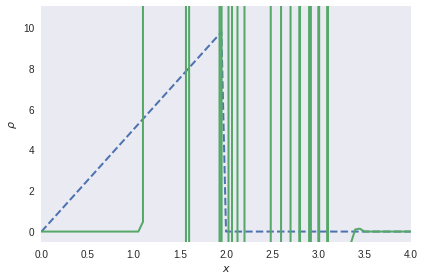

In [10]:
# timestep 30
traffic_cfl(30, rho0, L, nx, sigma, bc_value, rho_max, u_max)

Solution explodes when CFL=1. How about changing it to CFL=0.1?

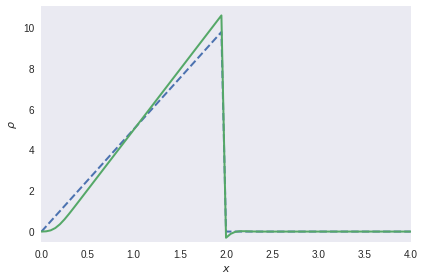

In [13]:
sigma = 0.1

# timestep 30
traffic_cfl(30, rho0, L, nx, sigma, bc_value, rho_max, u_max)

Doesn't help.

Explanation: It's not because of CFL, mostly because when $\rho=\frac{1}{2}\rho_{max}$, the derivative $\frac{\partial \rho}{\partial x}$ becomes negative (discussed more next). This will be solved using Upwind scheme. 

## Upwind scheme

My derivation to come up with $u_{wave}$ in Equation 15 (Prof L. Barba notebook Module 3 Lesson 1)

$$F=\rho u_{max} (1-\frac{\rho}{\rho_{max}})$$

Taking the derivative $\frac{\partial F}{\partial \rho}$ and using $(u \cdot \nu)'=u'\nu+u\nu'$

$$\frac{\partial F}{\partial \rho}=u_{max} (1-\frac{\rho}{\rho_{max}})+\rho u_{max} (-\frac{1}{\rho_{max}})$$

$$\frac{\partial F}{\partial \rho}=u_{max} (1-\frac{\rho}{\rho_{max}})-u_{max} (\frac{\rho}{\rho_{max}})$$

$$\frac{\partial F}{\partial \rho}=u_{max} (1-2\frac{\rho}{\rho_{max}})$$

When $\rho=\frac{1}{2} \rho_{max}$, then $(1-2\frac{\rho}{\rho_{max}})=0$, so $\frac{\partial F}{\partial \rho}=0$

Now, if $\rho>\frac{1}{2} \rho_{max}$, then $(1-2\frac{\rho}{\rho_{max}})>0$, so $\frac{\partial F}{\partial \rho}$ becomes negative

That's why as Prof L. Barba says, the derivative changes direction and makes the simulation unstable. 

So let's reduce the $\rho_{max}=10$ to $\rho_{max}=5$. We will come up with the following initial condition:

\begin{equation}\rho(x,0) = \left\{ \begin{array}{cc}
2.5 x & 0 \leq x < 2  \\
0 & 2 \leq x \leq 4 \\ \end{array} \right.\end{equation}

If all values of $\rho \leq \rho_{\rm max}/2$, then $\frac{\partial F}{\partial \rho}$ is positive everywhere.

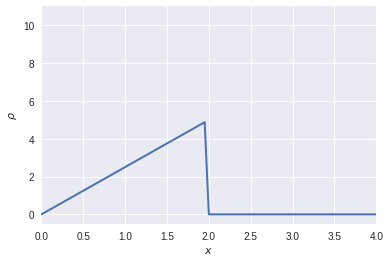

In [20]:
# set parameters for initial condition
nx = 81 # number of locations along the road
L = 4 # length of road
rho_max = 5 # car density along the road

rho0 = initialize_traffic(nx, L, rho_max)

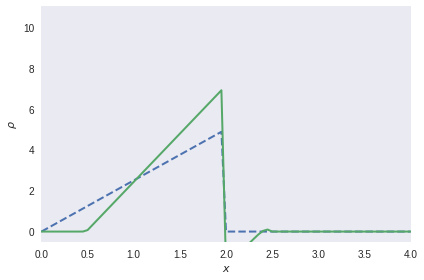

In [22]:
# Set parameters for simulation
nt = 30
L = 4
nx = 81
sigma = 1
bc_value = rho0[0]
u_max = 1

# timestep 2
traffic_cfl(10, rho0, L, nx, sigma, bc_value, rho_max, u_max)